In [1]:
import xgboost as xgb
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from scipy.stats import zscore

import seaborn as sns
sns.set(font='Yu Gothic')
import matplotlib.pyplot as plt
%matplotlib inline

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [ ]:
def load_npy(hold_position):
    file_path = "../Output/train/train_" + hold_position + "/train_" + hold_position
    xy_mean = np.load(file_path + "_glo_accel_xy_mean.npy")
    xy_var = np.load(file_path + "_glo_accel_xy_var.npy")
    z_mean = np.load(file_path + "_glo_accel_z_mean.npy")
    z_var = np.load(file_path + "_glo_accel_z_var.npy")
    z_skew_kurtosis = np.load(file_path + "_glo_accel_z_skew_kurtosis.npy")
    z_FFT = np.load(file_path + "_glo_accel_z_amplitude_frequency.npy")
    result = np.concatenate([xy_mean.reshape([-1, 1]), xy_var.reshape([-1, 1]), z_mean.reshape([-1, 1]), z_var.reshape([-1, 1]), z_skew_kurtosis, z_FFT], axis=1)
    del xy_mean, xy_var, z_mean, z_var, z_skew_kurtosis, z_FFT
    return result

In [2]:
def load_npy(hold_position):
    file_path = "../Output/train/train_" + hold_position + "/train_" + hold_position
    xy_mean = np.load(file_path + "_glo_laccel_xy_mean.npy")
    xy_var = np.load(file_path + "_glo_laccel_xy_var.npy")
    z_mean = np.load(file_path + "_glo_laccel_z_mean.npy")
    z_var = np.load(file_path + "_glo_laccel_z_var.npy")
    z_skew = np.load(file_path + "_glo_laccel_z_skew.npy")
    z_kurtosis = np.load(file_path + "_glo_laccel_z_kurtosis.npy")
    z_lacc_FFT = np.load(file_path + "_glo_laccel_z_amplitude_frequency_range5Hz.npy")
    z_gyro_FFT = np.load(file_path + "_glo_gyro_z_ver2_amplitude_frequency_range5Hz.npy")
    result = np.concatenate([xy_mean.reshape([-1, 1]), xy_var.reshape([-1, 1]), z_mean.reshape([-1, 1]), z_var.reshape([-1, 1]), z_skew.reshape([-1, 1]), z_kurtosis.reshape([-1, 1]), z_lacc_FFT, z_gyro_FFT], axis=1)
    del xy_mean, xy_var, z_mean, z_var, z_skew, z_kurtosis, z_gyro_FFT
    return result

In [3]:
train_Bag = np.delete(load_npy("Bag"), 120845, 0)
train_Hips = np.delete(load_npy("Hips"), 120845, 0)
train_Torso = np.delete(load_npy("Torso"), 120845, 0)
train_Hand = np.delete(load_npy("Hand"), 120845, 0)

train_Bag.shape

(195490, 50)

In [ ]:
# trainデータを前後に分割
train_Bag1, train_Bag2 = train_test_split(train_Bag, test_size=0.8, shuffle=False)
train_Hips1, train_Hips2 = train_test_split(train_Hips, test_size=0.8, shuffle=False)
train_Torso1, train_Torso2 = train_test_split(train_Torso, test_size=0.8, shuffle=False)
train_Hand1, train_Hand2 = train_test_split(train_Hand, test_size=0.8, shuffle=False)

train_Bag1.shape, train_Bag2.shape

In [ ]:
X_train = np.concatenate([train_Bag1, train_Hips1, train_Torso1, train_Hand1], axis=0)
X_train.shape

In [ ]:
X_test = np.concatenate([train_Bag2, train_Hips2, train_Torso2, train_Hand2], axis=0)
X_test.shape

In [4]:
X_train = np.concatenate([train_Bag, train_Hips, train_Torso, train_Hand], axis=0)
X_train.shape

(781960, 50)

In [ ]:
Y = np.load("../Data/センサ別npyファイル/train/train_Bag/train_Bag_Label.npy")[:, 0]
Y_train, Y_test = train_test_split(Y, test_size=0.8, shuffle=False)
Y_train.shape, Y_test.shape

In [ ]:
Y_train = np.concatenate([Y_train, Y_train, Y_train, Y_train], axis=0)
Y_test = np.concatenate([Y_test, Y_test, Y_test, Y_test], axis=0)
Y_train.shape, Y_test.shape

In [5]:
Y_train = np.delete(np.load("../Data/センサ別npyファイル/train/train_Bag/train_Bag_Label.npy")[:, 0], 120845, 0)
Y_train = np.concatenate([Y_train, Y_train, Y_train, Y_train], axis=0)
Y_train.shape

(781960, 1)

In [ ]:
def load_npy(hold_position):
    xy_mean = np.load("../Output/validation/validation_" + hold_position + "_glo_laccel_xy_mean.npy")
    xy_var = np.load("../Output/validation/validation_" + hold_position + "_glo_laccel_xy_var.npy")
    z_mean = np.load("../Output/validation/validation_" + hold_position + "_glo_laccel_z_mean.npy")
    z_var = np.load("../Output/validation/validation_" + hold_position + "_glo_laccel_z_var.npy")
    z_skew_kurtosis = np.load("../Output/validation/validation_" + hold_position + "_glo_laccel_z_skew_kurtosis.npy")
    z_lacc_FFT = np.load("../Output/validation/validation_" + hold_position + "_glo_laccel_z_amplitude_frequency_range10Hz.npy")
    z_gyro_FFT = np.load("../Output/validation/validation_" + hold_position + "_glo_laccel_z_amplitude_frequency_range10Hz.npy")
    result = np.concatenate([xy_mean.reshape([-1, 1]), xy_var.reshape([-1, 1]), z_mean.reshape([-1, 1]), z_var.reshape([-1, 1]), z_skew_kurtosis, z_FFT], axis=1)
    del xy_mean, xy_var, z_mean, z_var, z_skew_kurtosis, z_FFT
    return result

In [6]:
def load_npy(hold_position):
    file_path = "../Output/validation/validation_" + hold_position + "/validation_" + hold_position
    xy_mean = np.load(file_path + "_glo_laccel_xy_mean.npy")
    xy_var = np.load(file_path + "_glo_laccel_xy_var.npy")
    z_mean = np.load(file_path + "_glo_laccel_z_mean.npy")
    z_var = np.load(file_path + "_glo_laccel_z_var.npy")
    z_skew = np.load(file_path + "_glo_laccel_z_skew.npy")
    z_kurtosis = np.load(file_path + "_glo_laccel_z_kurtosis.npy")
    z_lacc_FFT = np.load(file_path + "_glo_laccel_z_amplitude_frequency_range5Hz.npy")
    z_gyro_FFT = np.load(file_path + "_glo_gyro_z_ver2_amplitude_frequency_range5Hz.npy")
    result = np.concatenate([xy_mean.reshape([-1, 1]), xy_var.reshape([-1, 1]), z_mean.reshape([-1, 1]), z_var.reshape([-1, 1]), z_skew.reshape([-1, 1]), z_kurtosis.reshape([-1, 1]), z_lacc_FFT, z_gyro_FFT], axis=1)
    del xy_mean, xy_var, z_mean, z_var, z_skew, z_kurtosis, z_gyro_FFT
    return result

In [7]:
validation_Bag = load_npy("Bag")
validation_Hips = load_npy("Hips")
validation_Torso = load_npy("Torso")
validation_Hand = load_npy("Hand")

validation_Bag.shape

(28685, 50)

In [8]:
X_val = np.concatenate([validation_Bag, validation_Hips, validation_Torso, validation_Hand], axis=0)
X_val.shape

(114740, 50)

In [9]:
Y_val = np.load("../Data/センサ別npyファイル/validation/validation_Bag/validation_Bag_Label.npy")[:, 0].reshape([-1, 1])
Y_val.shape

(28685, 1)

In [10]:
Y_val = Y_val.reshape([-1, 1])
Y_val = np.concatenate([Y_val, Y_val, Y_val, Y_val], axis=0)
Y_val.shape

(114740, 1)

In [11]:
Y_val_hold_position = np.zeros((28685*4, 1))
for i in range(4):
    Y_val_hold_position[28685*i:28685*(i+1)] = i
Y_val_hold_position.shape

(114740, 1)

In [12]:
Y_val = np.concatenate([Y_val, Y_val_hold_position], axis=1)
Y_val.shape

(114740, 2)

In [ ]:
train_Y = np.load("../Data/センサ別npyファイル/train/train_Bag/train_Bag_Label.npy")[:, 0]
train_Y.shape

In [ ]:
val_Y = np.load("../Data/センサ別npyファイル/validation/validation_Bag/validation_Bag_Label.npy")[:, 0].reshape([-1, 1])
val_Y.shape

In [ ]:
val_Y = val_Y.reshape([-1, 1])
val_Y.shape

In [ ]:
Y_train[Y_train >= 5] = 1
Y_test[Y_test >= 5] = 1

In [13]:
Y_train[Y_train >= 5] = 1
Y_val[Y_val >= 5] = 1

In [ ]:
Y_train[Y_train >= 5] = 1
Y_val[Y_val >= 5] = 1

train_Y[train_Y >= 5]  = 1
val_Y[val_Y >= 5] = 1

## 標準化(sklearn)

In [14]:
train_std = StandardScaler()
val_std = StandardScaler()

X_train[:, [0,1,2,3,4,5,6,8,10,12,14,16,18,20,22,24,26,28,30,32,34,36,38,40,42,44,46,48]] = train_std.fit_transform(X_train[:, [0,1,2,3,4,5,6,8,10,12,14,16,18,20,22,24,26,28,30,32,34,36,38,40,42,44,46,48]])
X_val[:, [0,1,2,3,4,5,6,8,10,12,14,16,18,20,22,24,26,28,30,32,34,36,38,40,42,44,46,48]] = val_std.fit_transform(X_val[:, [0,1,2,3,4,5,6,8,10,12,14,16,18,20,22,24,26,28,30,32,34,36,38,40,42,44,46,48]])
# X_test[:, [0,1,2,3,4,5,6,8,10,12,14,16,18,20,22,24,26,28,30,32,34,36,38,40,42,44,46,48]] = std.transform(X_test[:, [0,1,2,3,4,5,6,8,10,12,14,16,18,20,22,24,26,28,30,32,34,36,38,40,42,44,46,48]])

X_train.shape, X_val.shape

((781960, 50), (114740, 50))

## 有効桁数を減らす（Deep Learningでは精度上がったが，XGBoostでは精度上がらなかった）

In [ ]:
X_train = np.round(X_train, 5)
X_val = np.round(X_val, 5)
X_train

In [ ]:
from sklearn.model_selection import train_test_split

X_val_train, X_val_test, Y_val_train, Y_val_test = train_test_split(X_val, Y_val, test_size=0.8)
X_val_train.shape, Y_val_train.shape, X_val_test.shape, Y_val_test.shape

In [ ]:
train_Still = X_train[(Y_train==1)[:, 0]]
train_Walking = X_train[(Y_train==2)[:, 0]]
train_Run = X_train[(Y_train==3)[:, 0]]
train_Bike = X_train[(Y_train==4)[:, 0]]

train_Still.shape, train_Walking.shape, train_Run.shape, train_Bike.shape

In [ ]:
# train_Still = train_Still[np.random.choice(train_Still.shape[0], 33700, replace=False)]
train_Walking = train_Walking[np.random.choice(train_Walking.shape[0], 33700, replace=False)]
train_Bike = train_Bike[np.random.choice(train_Bike.shape[0], 33700, replace=False)]

train_Still.shape, train_Walking.shape, train_Bike.shape

In [ ]:
X_train = np.concatenate([train_Still, train_Walking, train_Run, train_Bike], axis=0)
Y_train = [1] * 557016 + [2] * 33700 + [3] * 33700 + [4] * 33700
Y_train = np.array(Y_train).reshape([-1, 1])
X_train.shape, Y_train.shape

In [15]:
model = xgb.XGBClassifier(max_depth=18, min_child_weight=7, learning_rate=0.1, 
                          n_jobs=-1, tree_method='gpu_hist', gpu_id=0,
                         gamma=0.1, sub_sample=1.0, colsample_bytree=1.0)
# model.fit(X_val_train, Y_val_train[:, 0])
model.fit(X_train, Y_train)

C:\Users\Owner\Anaconda3\envs\GPU\lib\site-packages\sklearn\preprocessing\_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Owner\Anaconda3\envs\GPU\lib\site-packages\sklearn\preprocessing\_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1.0, gamma=0.1, gpu_id=0,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.1, max_delta_step=0, max_depth=18,
              min_child_weight=7, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=-1, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, sub_sample=1.0, subsample=1,
              tree_method='gpu_hist', validate_parameters=False,
              verbosity=None)

In [16]:
def plot_confusion_matrix(test_y,pred_y,class_names,normalize=False):
    cm = confusion_matrix(test_y,pred_y)
    # classes = class_names[unique_labels(test_y,pred_y)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    fig, ax = plt.subplots(figsize=(16, 8))
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=class_names,
           yticklabels=class_names,
           ylabel='True label\n',
           xlabel='\nPredicted label')
    fmt = '.2f' if normalize else 'd'
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j,
                    i,
                    format(cm[i, j], fmt),
                    ha="center",
                    va="center",
                    color="red", fontsize=32)
    fig.tight_layout()
    return ax

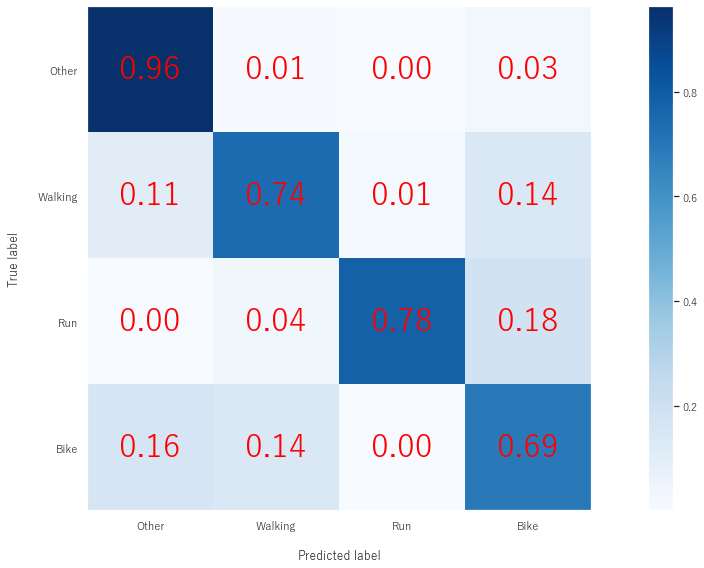

In [17]:
class_names = ['Other', 'Walking', 'Run', 'Bike']
# class_names = ['Still', 'Walking', 'Run', 'Bike', 'Car', 'Bus', 'Train', 'Subway']
predict = model.predict(X_val)
plot_confusion_matrix(Y_val[:, 0], predict, class_names, True)
plt.grid(False)

In [ ]:
predict.shape, Y_val_test.shape

In [ ]:
Y_val_test[Y_val_test[:, 1]==i][:, 0], predict[Y_val_test[:, 1]==i]

0.801
0.77
0.777
0.827


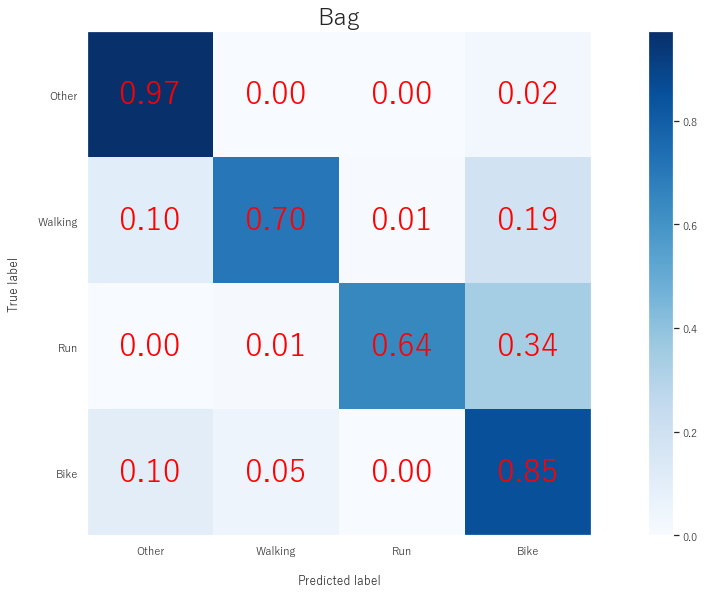

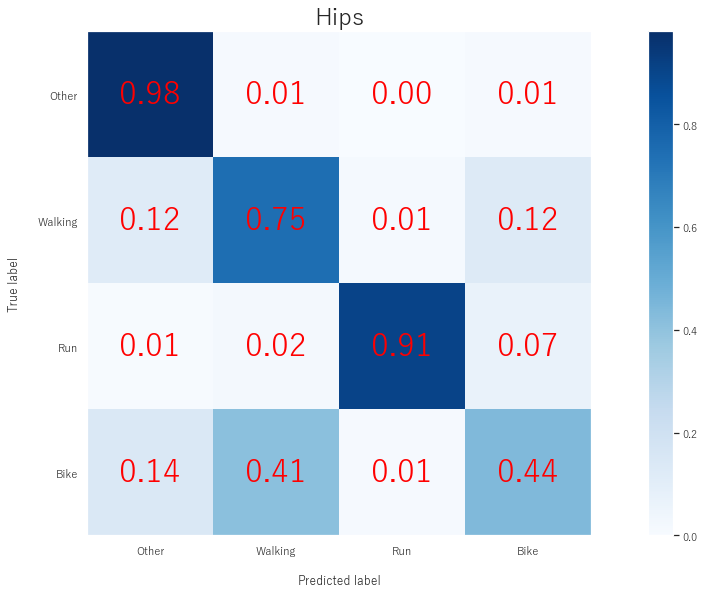

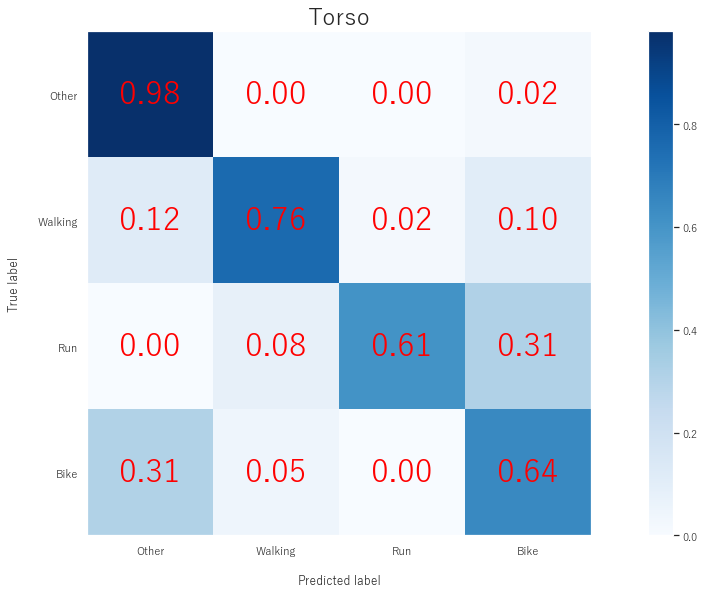

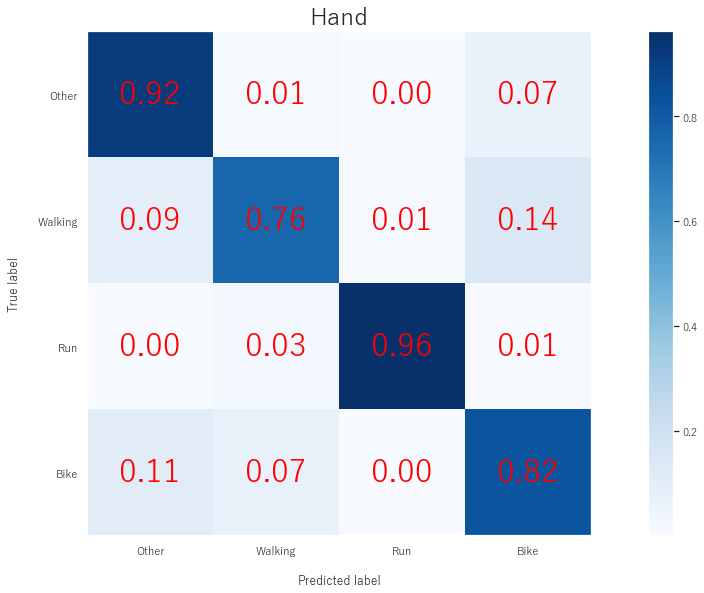

In [18]:
from sklearn.metrics import f1_score
hold_positions = ["Bag", "Hips", "Torso", "Hand"]
for i in range(4):
    plot_confusion_matrix(Y_val[Y_val[:, 1]==i][:, 0], predict[Y_val[:, 1]==i], class_names, True)
    print(round(f1_score(Y_val[Y_val[:, 1]==i][:, 0], predict[Y_val[:, 1]==i], average='macro'), 3))
    plt.title(hold_positions[i], fontsize=24)
    plt.grid(False)

In [19]:
from sklearn.metrics import f1_score
f1_macro = f1_score(Y_val[:, 0], predict, average='macro')
round(f1_macro, 3)

0.797

In [ ]:
predict = model.predict(X_val_train)
cm = confusion_matrix(Y_val_train, predict)
cm

In [ ]:
f1_macro = f1_score(Y_val_train, predict, average='macro')
f1_macro

In [ ]:
_, ax = plt.subplots(figsize=(12, 10))
xgb.plot_importance(model,
                    ax=ax,
                    importance_type='gain',
                    show_values=False)
plt.grid(False)

In [24]:
best_f1_score = 0
best_param = {}

max_depth = [0.005, 0.01, 0.05]#[1.0, 0.95, 0.90, 0.85, 0.80]
min_child_weight = [0]#[1.0, 0.95, 0.90, 0.85, 0.80]
count = 1
for i in max_depth:
    for j in min_child_weight:
        model = xgb.XGBClassifier(max_depth=18, min_child_weight=7, learning_rate=0.1, gamma=i,
                                  n_jobs=-1, tree_method='gpu_hist', gpu_id=0)
        model.fit(X_train, Y_train)
        print("{}回終わった".format(count))
        count += 1
        predict = model.predict(X_val)
        f1_macro = f1_score(Y_val[:, 0], predict, average='macro')
        print({'max_depth': i, 'min_child_weight': j}, f1_macro)
        if f1_macro > best_f1_score:
            best_f1_score = f1_macro
            best_param = {'max_depth': i, 'min_child_weight': j}

print(round(best_f1_score, 3))
print(best_param)

# param = {
#     "max_depth":[i for i in range(3, 16, 3)], "min_child_weight":[i for i in range(6, 13, 2)]
#     # "gamma":[0.01, 0.05, 0.075, 0.1]
#     # "subsample":[0.70, 0.75, 0.80, 0.85, 0.90, 0.95, 1.00], "colsample_bytree":[0.70, 0.75, 0.80, 0.85, 0.90, 0.95, 1.00]
#     # "n_estimators":[250, 500, 750], "learning_rate":[0.05, 0.1]
#     # "reg_alpha":[0.1, 0.25, 0.5, 0.75]
# }

1回終わった
{'max_depth': 0.005, 'min_child_weight': 0} 0.7982187240430721
2回終わった
{'max_depth': 0.01, 'min_child_weight': 0} 0.7977006921687437
3回終わった
{'max_depth': 0.05, 'min_child_weight': 0} 0.7981108349822474
0.798
{'max_depth': 0.005, 'min_child_weight': 0}


## データの分布を確認することは重要

In [ ]:
test_size = X_test.shape[0]//4

In [ ]:
Y_train = Y_train[~np.isnan(X_train)[:, 0]].reshape([-1, 1])
X_train = X_train[~np.isnan(X_train)[:, 0], :]
X_train.shape, Y_train.shape

In [ ]:
hold_positions = ['Bag', 'Hips', 'Torso', 'Hand']
train = [train_Bag, train_Hips, train_Torso, train_Hand]
test = [validation_Bag, validation_Hips, validation_Torso, validation_Hand]
moving_states = ['Still（乗り物も）', 'Walking', 'Run', 'Bike']

sensors = ["世界座標系線形加速度XY平均", "世界座標系線形加速度XY分散", "世界座標系線形加速度Z平均", "世界座標系線形加速度Z分散", "世界座標系線形加速度Z歪度", "世界座標系線形加速度Z尖度", "世界座標系線形加速度Z_FFT_MaxAmplitude", "世界座標系線形加速度Z_FFT_MaxAmplitude_Frequency"]

def hist_plot(sensor):
    fig = plt.figure(figsize=(24, 16))

    plt.subplots_adjust(wspace=0.4, hspace=0.2)
    print(sensor)
    for i in range(4):
        for j in range(4):
            plt.subplot(4, 4, i*4 + (j+1))
            try:
                sns.distplot(zscore(train[i], axis=1)[:, sensor].reshape([-1, 1])[train_Y==j+1], bins=21, label='train_' + hold_positions[i] + "_" + moving_states[j])
#                 sns.distplot(zscore(train[i][:, [0,1,2,3,4,5,6,8,10,12,14,16,18,20,22,24,26,28,30,32,34,36,38,40,42,44,46,48]], axis=1)[:, sensor].reshape([-1, 1])[train_Y==j+1], bins=21, label='train_' + hold_positions[i] + "_" + moving_states[j])
#                 sns.distplot(zscore(test[i][:, [0,1,2,3,4,5,6,8,10,12,14,16,18,20,22,24,26,28,30,32,34,36,38,40,42,44,46,48]], axis=1)[:, sensor].reshape([-1, 1])[test_Y==j+1], bins=21, label='val_' + hold_positions[i] + "_" + moving_states[j])
            except:
                print("やらかし")
                pass
#     fig.suptitle(sensors[sensor], fontsize=20)
    plt.show()

In [ ]:
sns.distplot(X_train[:, 5])
X_train[0].mean()

In [ ]:
for i in range(X_train.shape[1]):
    hist_plot(i)

In [ ]:
fig = plt.figure(figsize=(24, 16))

plt.subplots_adjust(wspace=0.4, hspace=0.2)

for i in range(4):
    for j in range(4):
        plt.subplot(4, 4, i*4 + (j+1))
        sns.distplot(train[i][:, 3].reshape([-1, 1])[train_Y==j+1], bins=21, label='train_' + hold_positions[i] + "_" + moving_states[j])
        sns.distplot(test[i][:, 3].reshape([-1, 1])[test_Y==j+1], bins=21, label='val_' + hold_positions[i] + "_" + moving_states[j])
        plt.xlim(-1, 10000)
        plt.ylim(0, 0.003)
        plt.legend()
fig.suptitle(sensors[3], fontsize=20)
plt.show()

In [ ]:
from scipy.stats import zscore

def hist_plot(sensor):
    fig = plt.figure(figsize=(24, 16))

    plt.subplots_adjust(wspace=0.4, hspace=0.2)

    for i in range(4):
        train_std = train[i][np.isnan(train[i]).any(axis=1) == False].reshape([-1, X_train.shape[1]])
        train_Y_std = train_Y[np.isnan(train[i]).any(axis=1) == False]
        train_std = (train_std - train_std.mean()) / train_std.std()
        test_std = (test[i] - test[i].mean()) / test[i].std()
#         train_std = StandardScaler().fit_transform(train_std[:, sensor].reshape([-1, 1]))
#         test_std = StandardScaler().fit_transform(test[i][:, sensor].reshape([-1, 1]))
        print(train_std.mean(), test_std.mean())
        print(train_std.var(), test_std.var())
        for j in range(4):
            plt.subplot(4, 4, i*4 + (j+1))
            sns.distplot(train_std[:, sensor].reshape([-1, 1])[train_Y_std==j+1], bins=21, label='train_' + hold_positions[i] + "_" + moving_states[j])
            sns.distplot(test_std[:, sensor].reshape([-1, 1])[test_Y==j+1], bins=21, label='val_' + hold_positions[i] + "_" + moving_states[j])
            plt.legend()
#     fig.suptitle(sensors[sensor], fontsize=20)
    plt.show()

In [ ]:
# plt.plot(zscore(train[0][:, 0], axis=0))
np.where(np.isnan(train[1]))

In [ ]:
np.where(np.isinf(train[1]))

In [ ]:
# それぞれのスケールで標準化した特徴量をプロット
for i in range(X_train.shape[1]):
    hist_plot(i)